# Executive Summary (Part 2)
### Goal
#### Building on the earlier classification analysis, the aim for part 2 is to segment the population of loan recipients whom defaulted in order to identify attributes that may help to group these applicants for further engagement and management.
### Metrics
#### Silhouette Score
### Findings
#### Both the KMeans Clustering and Agglomerative (Hierarchical) Clustering models produce similar results with maximum Silhouette Score of about 0.54. However, the high number of clusters associated with these best scores lead to less than interpretable results.

#### For business reasons, if the desired number of groups is 2, the features associated with each group are broadly classified as follows (and an associated sample Silhouette Score using the Hierarchical Clustering model is 0.42)
#### Group 1: Borrowers with Credit Subgrades F1 and below 
#### Group 2: Borrowers with Credit Subgrades E5 and above 
### Risks/Limitations/Assumptions
#### To reduce the dimensionality of the data and generate meaningful insights, feature selection was done manually so as to reduce the number of features and work with attributes that have greater interpretability. This meant that a significant amount of the data (ie the financial background of the individual) was lost in the process.
#### Given the rather normal distribution of the features selected, the eventual grouping is also rather arbitrary. Though this may help in formulating schemes for intervention with the different groups, this selection could have also been done via manually assigning numerical cutoffs for the features of interest to segment the population of defaulters.

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics
from pandas.plotting import radviz
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MiniBatchKMeans, AffinityPropagation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import cdist

pd.set_option('display.max_columns', 200)
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)

# Data Preparation

In [2]:
data = pd.read_pickle('dataupdate28042018.pkl')
# data.head()

In [3]:
# Getting only the data associated with the defaulters
Xdef = data
Xdef.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,DEFAULT
42536,27050.0,27050.0,27050.0,36 months,10.99,885.46,B,B2,team leadern customer ops & systems,10+ years,OWN,55000.0,Verified,Dec-2013,debt_consolidation,481xx,MI,22.87,0.0,Oct-1986,0.0,0.0,14.0,0.0,36638.0,61.2%,27.0,w,10018.90,10018.90,21251.04,21251.04,17031.10,4219.94,0.0,0.0,0.0,885.46,Feb-2016,Dec-2015,0.0,INDIVIDUAL,0.0,0.0,114834.0,59900.0,0
42537,9750.0,9750.0,9750.0,36 months,13.98,333.14,C,C1,medical assistant,1 year,RENT,26000.0,Not Verified,Dec-2013,debt_consolidation,927xx,CA,25.12,0.0,Jan-2007,0.0,0.0,12.0,0.0,7967.0,52.8%,28.0,f,3710.96,3710.96,7994.83,7994.83,6039.04,1955.79,0.0,0.0,0.0,333.14,Feb-2016,Jan-2016,0.0,INDIVIDUAL,0.0,0.0,14123.0,15100.0,0
42538,12000.0,12000.0,12000.0,36 months,6.62,368.45,A,A2,manager information delivery,10+ years,MORTGAGE,105000.0,Not Verified,Dec-2013,debt_consolidation,060xx,CT,14.05,0.0,Mar-1994,1.0,43.0,12.0,0.0,13168.0,21.6%,22.0,w,4266.62,4266.62,8842.80,8842.80,7733.38,1109.42,0.0,0.0,0.0,368.45,Feb-2016,Jan-2016,0.0,INDIVIDUAL,0.0,0.0,267646.0,61100.0,0
42539,12000.0,12000.0,12000.0,36 months,13.53,407.40,B,B5,on road manager,10+ years,RENT,40000.0,Source Verified,Dec-2013,debt_consolidation,871xx,NM,16.94,0.0,Oct-1998,0.0,53.0,7.0,2.0,5572.0,68.8%,32.0,w,0.00,0.00,13359.77,13359.77,11999.99,1359.78,0.0,0.0,0.0,119.17,isthisrelevant?,Jan-2016,0.0,INDIVIDUAL,0.0,15386.0,13605.0,8100.0,0
42540,15000.0,15000.0,15000.0,36 months,8.90,476.30,A,A5,aircraft maintenance engineer,2 years,MORTGAGE,63000.0,Not Verified,Dec-2013,debt_consolidation,334xx,FL,16.51,0.0,Mar-1998,0.0,34.0,8.0,0.0,11431.0,74.2%,29.0,w,5449.27,5449.27,11431.20,11431.20,9550.73,1880.47,0.0,0.0,0.0,476.30,Feb-2016,Jan-2016,0.0,INDIVIDUAL,0.0,1514.0,272492.0,15400.0,0


In [4]:
Xdef.shape

(816676, 47)

### Doing some feature engineering for the categorical columns of interest

In [5]:
lbe = LabelEncoder()
# loan term
Xdef['term_num'] = lbe.fit_transform(Xdef['term'])
# loan grade
Xdef['grade_num'] = lbe.fit_transform(Xdef['grade'])
# loan sub_grade
Xdef['sub_grade_num'] = lbe.fit_transform(Xdef['sub_grade'])
# employment length
Xdef['emp_length_num'] = lbe.fit_transform(Xdef['emp_length'])
# home ownership
Xdef['home_ownership_num'] = lbe.fit_transform(Xdef['home_ownership'])
# loan purpose
Xdef['purpose_num'] = lbe.fit_transform(Xdef['purpose'])
# verification status
Xdef['verification_status_num'] = lbe.fit_transform(Xdef['verification_status'])

In [6]:
Xdef.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,DEFAULT,term_num,grade_num,sub_grade_num,emp_length_num,home_ownership_num,purpose_num,verification_status_num
42536,27050.0,27050.0,27050.0,36 months,10.99,885.46,B,B2,team leadern customer ops & systems,10+ years,OWN,55000.0,Verified,Dec-2013,debt_consolidation,481xx,MI,22.87,0.0,Oct-1986,0.0,0.0,14.0,0.0,36638.0,61.2%,27.0,w,10018.90,10018.90,21251.04,21251.04,17031.10,4219.94,0.0,0.0,0.0,885.46,Feb-2016,Dec-2015,0.0,INDIVIDUAL,0.0,0.0,114834.0,59900.0,0,0,1,6,1,4,2,2
42537,9750.0,9750.0,9750.0,36 months,13.98,333.14,C,C1,medical assistant,1 year,RENT,26000.0,Not Verified,Dec-2013,debt_consolidation,927xx,CA,25.12,0.0,Jan-2007,0.0,0.0,12.0,0.0,7967.0,52.8%,28.0,f,3710.96,3710.96,7994.83,7994.83,6039.04,1955.79,0.0,0.0,0.0,333.14,Feb-2016,Jan-2016,0.0,INDIVIDUAL,0.0,0.0,14123.0,15100.0,0,0,2,10,0,5,2,0
42538,12000.0,12000.0,12000.0,36 months,6.62,368.45,A,A2,manager information delivery,10+ years,MORTGAGE,105000.0,Not Verified,Dec-2013,debt_consolidation,060xx,CT,14.05,0.0,Mar-1994,1.0,43.0,12.0,0.0,13168.0,21.6%,22.0,w,4266.62,4266.62,8842.80,8842.80,7733.38,1109.42,0.0,0.0,0.0,368.45,Feb-2016,Jan-2016,0.0,INDIVIDUAL,0.0,0.0,267646.0,61100.0,0,0,0,1,1,1,2,0
42539,12000.0,12000.0,12000.0,36 months,13.53,407.40,B,B5,on road manager,10+ years,RENT,40000.0,Source Verified,Dec-2013,debt_consolidation,871xx,NM,16.94,0.0,Oct-1998,0.0,53.0,7.0,2.0,5572.0,68.8%,32.0,w,0.00,0.00,13359.77,13359.77,11999.99,1359.78,0.0,0.0,0.0,119.17,isthisrelevant?,Jan-2016,0.0,INDIVIDUAL,0.0,15386.0,13605.0,8100.0,0,0,1,9,1,5,2,1
42540,15000.0,15000.0,15000.0,36 months,8.90,476.30,A,A5,aircraft maintenance engineer,2 years,MORTGAGE,63000.0,Not Verified,Dec-2013,debt_consolidation,334xx,FL,16.51,0.0,Mar-1998,0.0,34.0,8.0,0.0,11431.0,74.2%,29.0,w,5449.27,5449.27,11431.20,11431.20,9550.73,1880.47,0.0,0.0,0.0,476.30,Feb-2016,Jan-2016,0.0,INDIVIDUAL,0.0,1514.0,272492.0,15400.0,0,0,0,4,2,1,2,0


In [107]:
#Xdef[Xdef['sub_grade_num']==24]

# Modelling

### Feature Selection

#### Getting subset of demographic and loan related features for further analysis

In [7]:
Xdef1 = Xdef[['loan_amnt','installment','int_rate','annual_inc','term_num','grade_num','sub_grade_num',\
              'emp_length_num','home_ownership_num','purpose_num','verification_status_num','tot_cur_bal',\
              'out_prncp','DEFAULT']]

#### Studying distribution of these points using radviz

Text(0.5,1,u'Scatter plot of selected features for analysis')

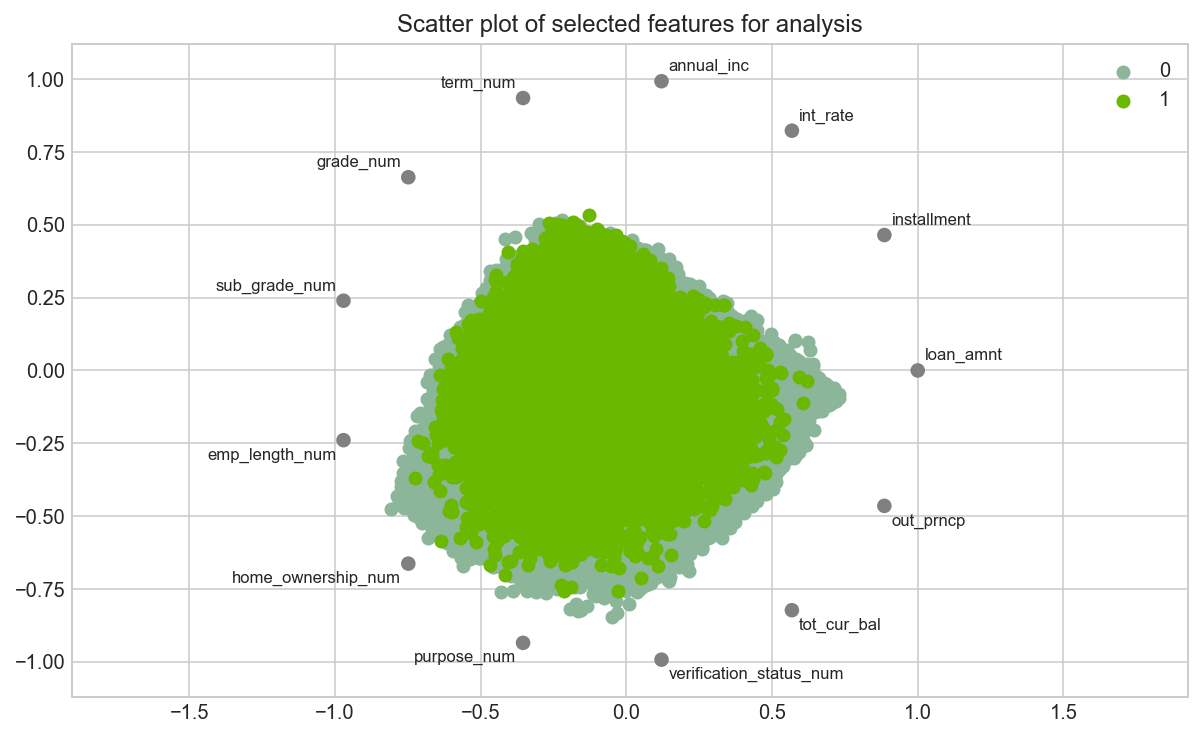

In [112]:
plt.figure(figsize=(10,6))
ax = radviz(Xdef1,'DEFAULT')
plt.title('Scatter plot of selected features for analysis')

#### It appears that there are no obvious clusters, but let's explore this further by subsetting the features which are more important for predicting default

In [12]:
numfeat = [x for x in Xdef1.columns if Xdef1[x].dtype != object]
Xdefnum = Xdef1[numfeat]
print("Most important numerical features for default")
Xdefcorr = Xdefnum.corr()
Xdefcorr.sort_values(['DEFAULT'], ascending = False, inplace = True)
print(Xdefcorr.DEFAULT)

Most important numerical features for default
DEFAULT                    1.000000
int_rate                   0.175336
sub_grade_num              0.146594
grade_num                  0.143162
verification_status_num    0.046778
home_ownership_num         0.033028
term_num                   0.032762
purpose_num                0.029058
installment                0.017823
emp_length_num             0.016928
loan_amnt                  0.004717
annual_inc                -0.032814
tot_cur_bal               -0.038381
out_prncp                 -0.169068
Name: DEFAULT, dtype: float64


#### These correlations can be used in deciding the features to be used for the subsequent clustering

#### Scaling down the size of data for ease of computation

In [8]:
df_train, df_test = train_test_split(Xdef1, test_size=0.9, stratify=Xdef['DEFAULT'])
df_train.shape

(81667, 14)

In [9]:
df_temp = df_train[df_train['DEFAULT']==1]
Xdef2 = df_temp.drop('DEFAULT',axis=1)

In [10]:
Xdef2.shape

(5019, 13)

#### Rather than using all these features, let's use the features with top four correlations

In [11]:
Xdef3 = Xdef2[['int_rate','sub_grade_num','out_prncp','grade_num']]
# 'grade_num','annual_inc','verification_status_num','home_ownership_num','term_num']]

In [12]:
mms = MinMaxScaler()
Xdeff = mms.fit_transform(Xdef3)

### Beginning Clustering

#### Try KMeans Clustering

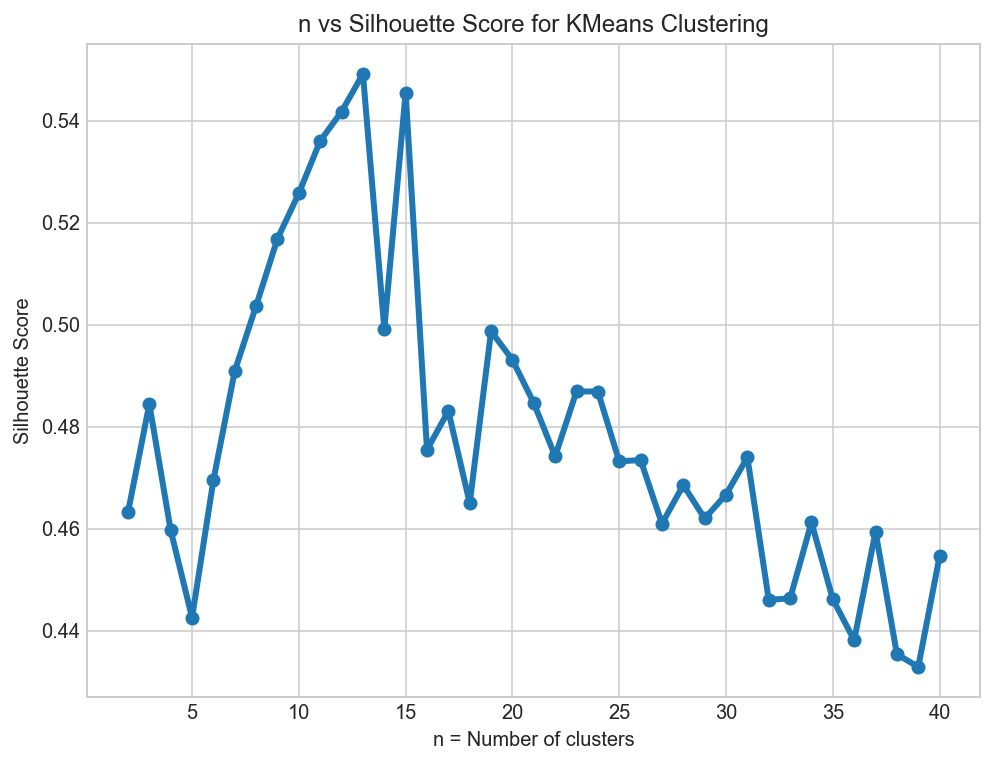

In [46]:
# plotting silhouette results for kmeans

templist = []
for i in range(2, 41):
    k_mean = KMeans(n_clusters=i,n_jobs=-1,init='k-means++')
    k_mean.fit(Xdeff)
    labels = k_mean.labels_
    templist.append(silhouette_score(Xdeff, labels))
    
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(2, 41), templist, lw=3., marker='o')
plt.xlabel('n = Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('n vs Silhouette Score for KMeans Clustering')
plt.show()

#### Best Silhouette Score is for n = 13, but at that level the clusters lack interpretability

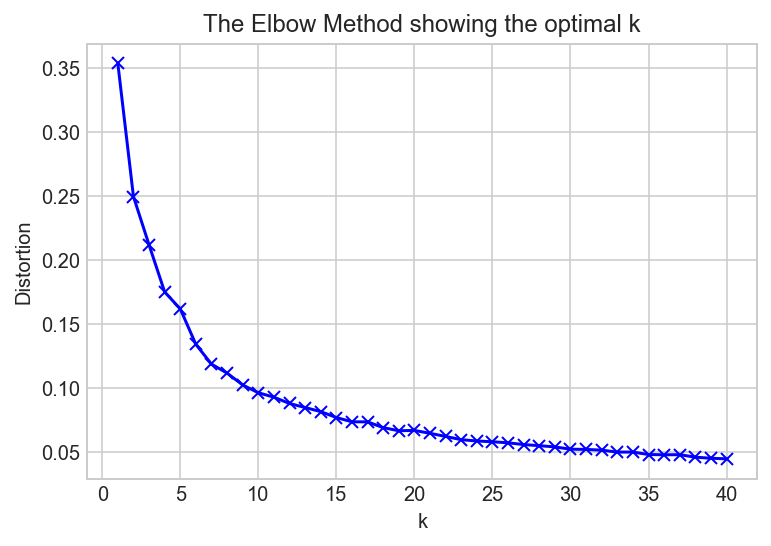

In [14]:
# finding out what elbow rule says
distortions = []
K = range(1,41)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(Xdeff)
    kmeanModel.fit(Xdeff)
    distortions.append(sum(np.min(cdist(Xdeff, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / Xdeff.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### Based on elbow rule, the number of ideal clusters could be anything from 2 to 7

In [49]:
# Xdef3 = Xdef3.drop(['clustershei'],axis=1)

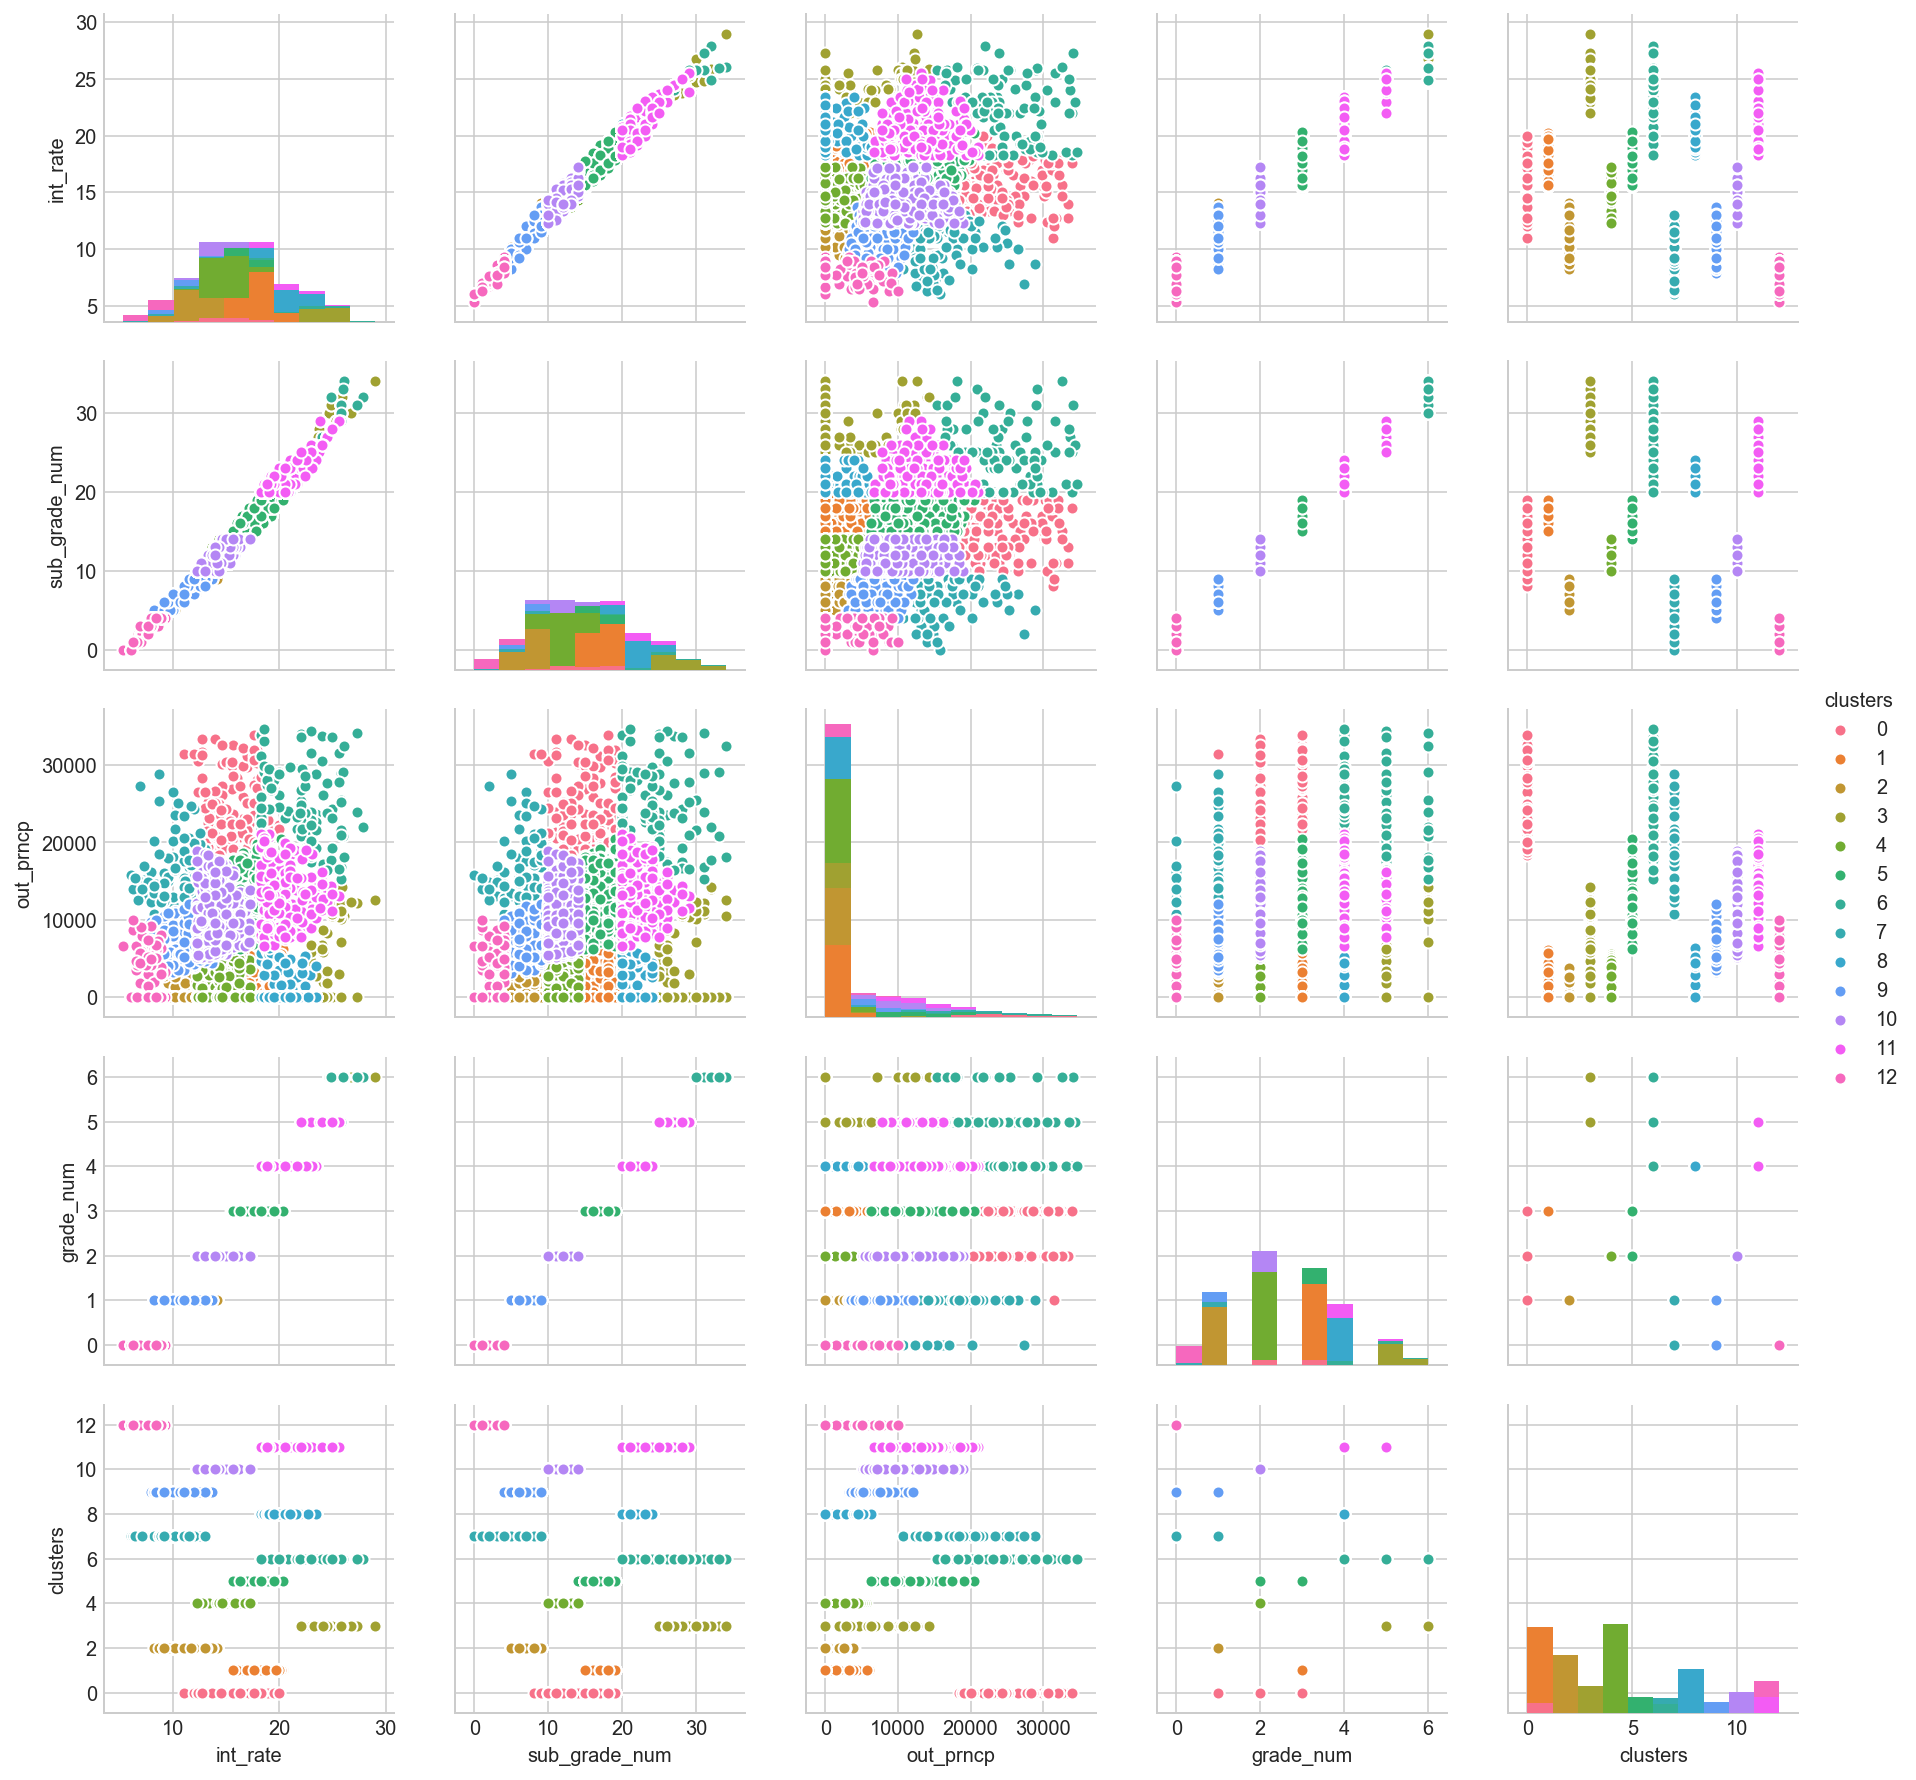

In [50]:
# visually examine the clusters that have been created using minmax scaler
Xdef3['clusters'] = labels
sns.pairplot(data=Xdef3, hue='clusters')

#### Try Mini Batch K Means

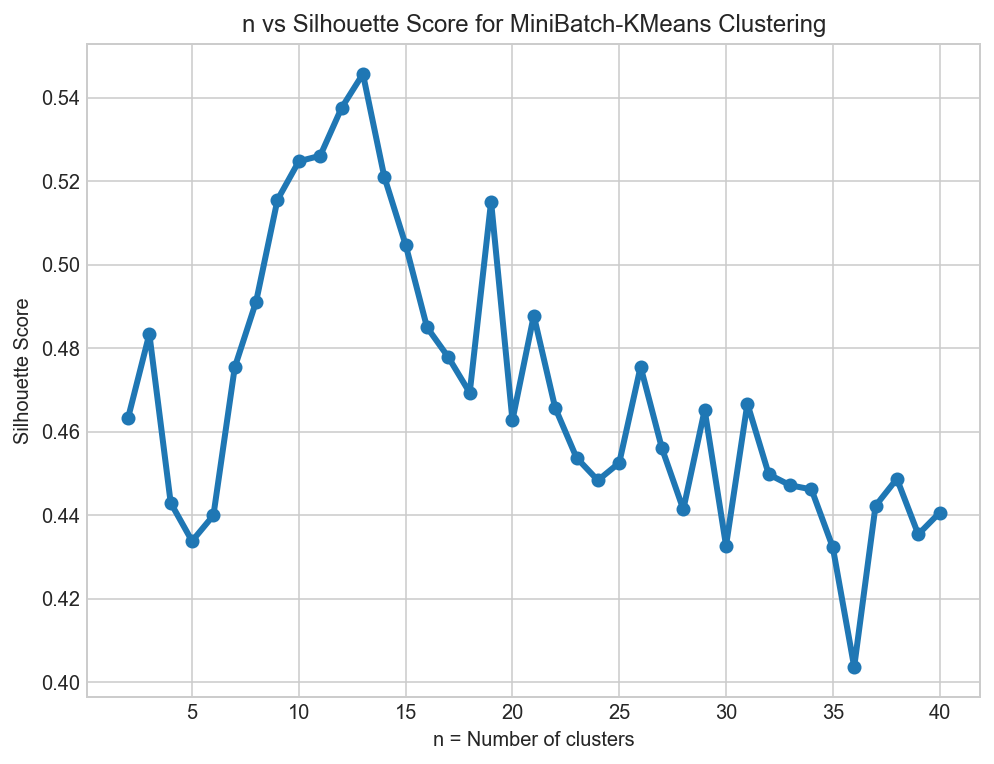

In [51]:
templist = []
for i in range(2, 41):
    k_meanmb = MiniBatchKMeans(n_clusters=i,init='k-means++')
    k_meanmb.fit(Xdeff)
    labels = k_meanmb.labels_
    templist.append(silhouette_score(Xdeff, labels))
    
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(2, 41), templist, lw=3., marker='o')
plt.xlabel('n = Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('n vs Silhouette Score for MiniBatch-KMeans Clustering')
plt.show()

#### Results appear to be similar to using KMeans so not proceeding further here

#### Try DBScan

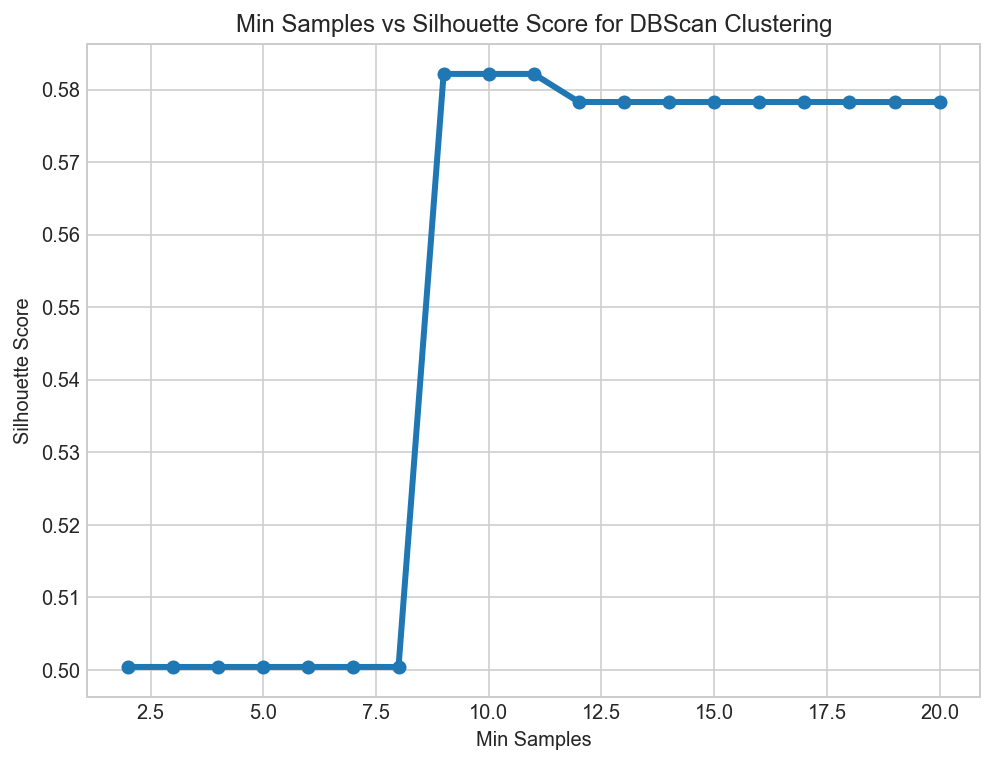

In [113]:
templist = []
for i in np.arange(2, 21, 1):
    dbscan = DBSCAN(eps = 0.2, min_samples = i,n_jobs=-1)
    dbscan.fit(Xdeff)
    labels = dbscan.labels_
    templist.append(silhouette_score(Xdeff, labels))
        
    
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.arange(2, 21, 1), templist, lw=3., marker='o')
plt.xlabel('Min Samples')
plt.ylabel('Silhouette Score')
plt.title('Min Samples vs Silhouette Score for DBScan Clustering')
plt.show()

In [80]:
dbscan = DBSCAN(eps = 0.2, min_samples = 10)
dbscan.fit(Xdeff)
labels = dbscan.labels_
print "DBScan silhouette Score:\t", silhouette_score(Xdeff, labels)

DBScan silhouette Score:	0.5821700672879007


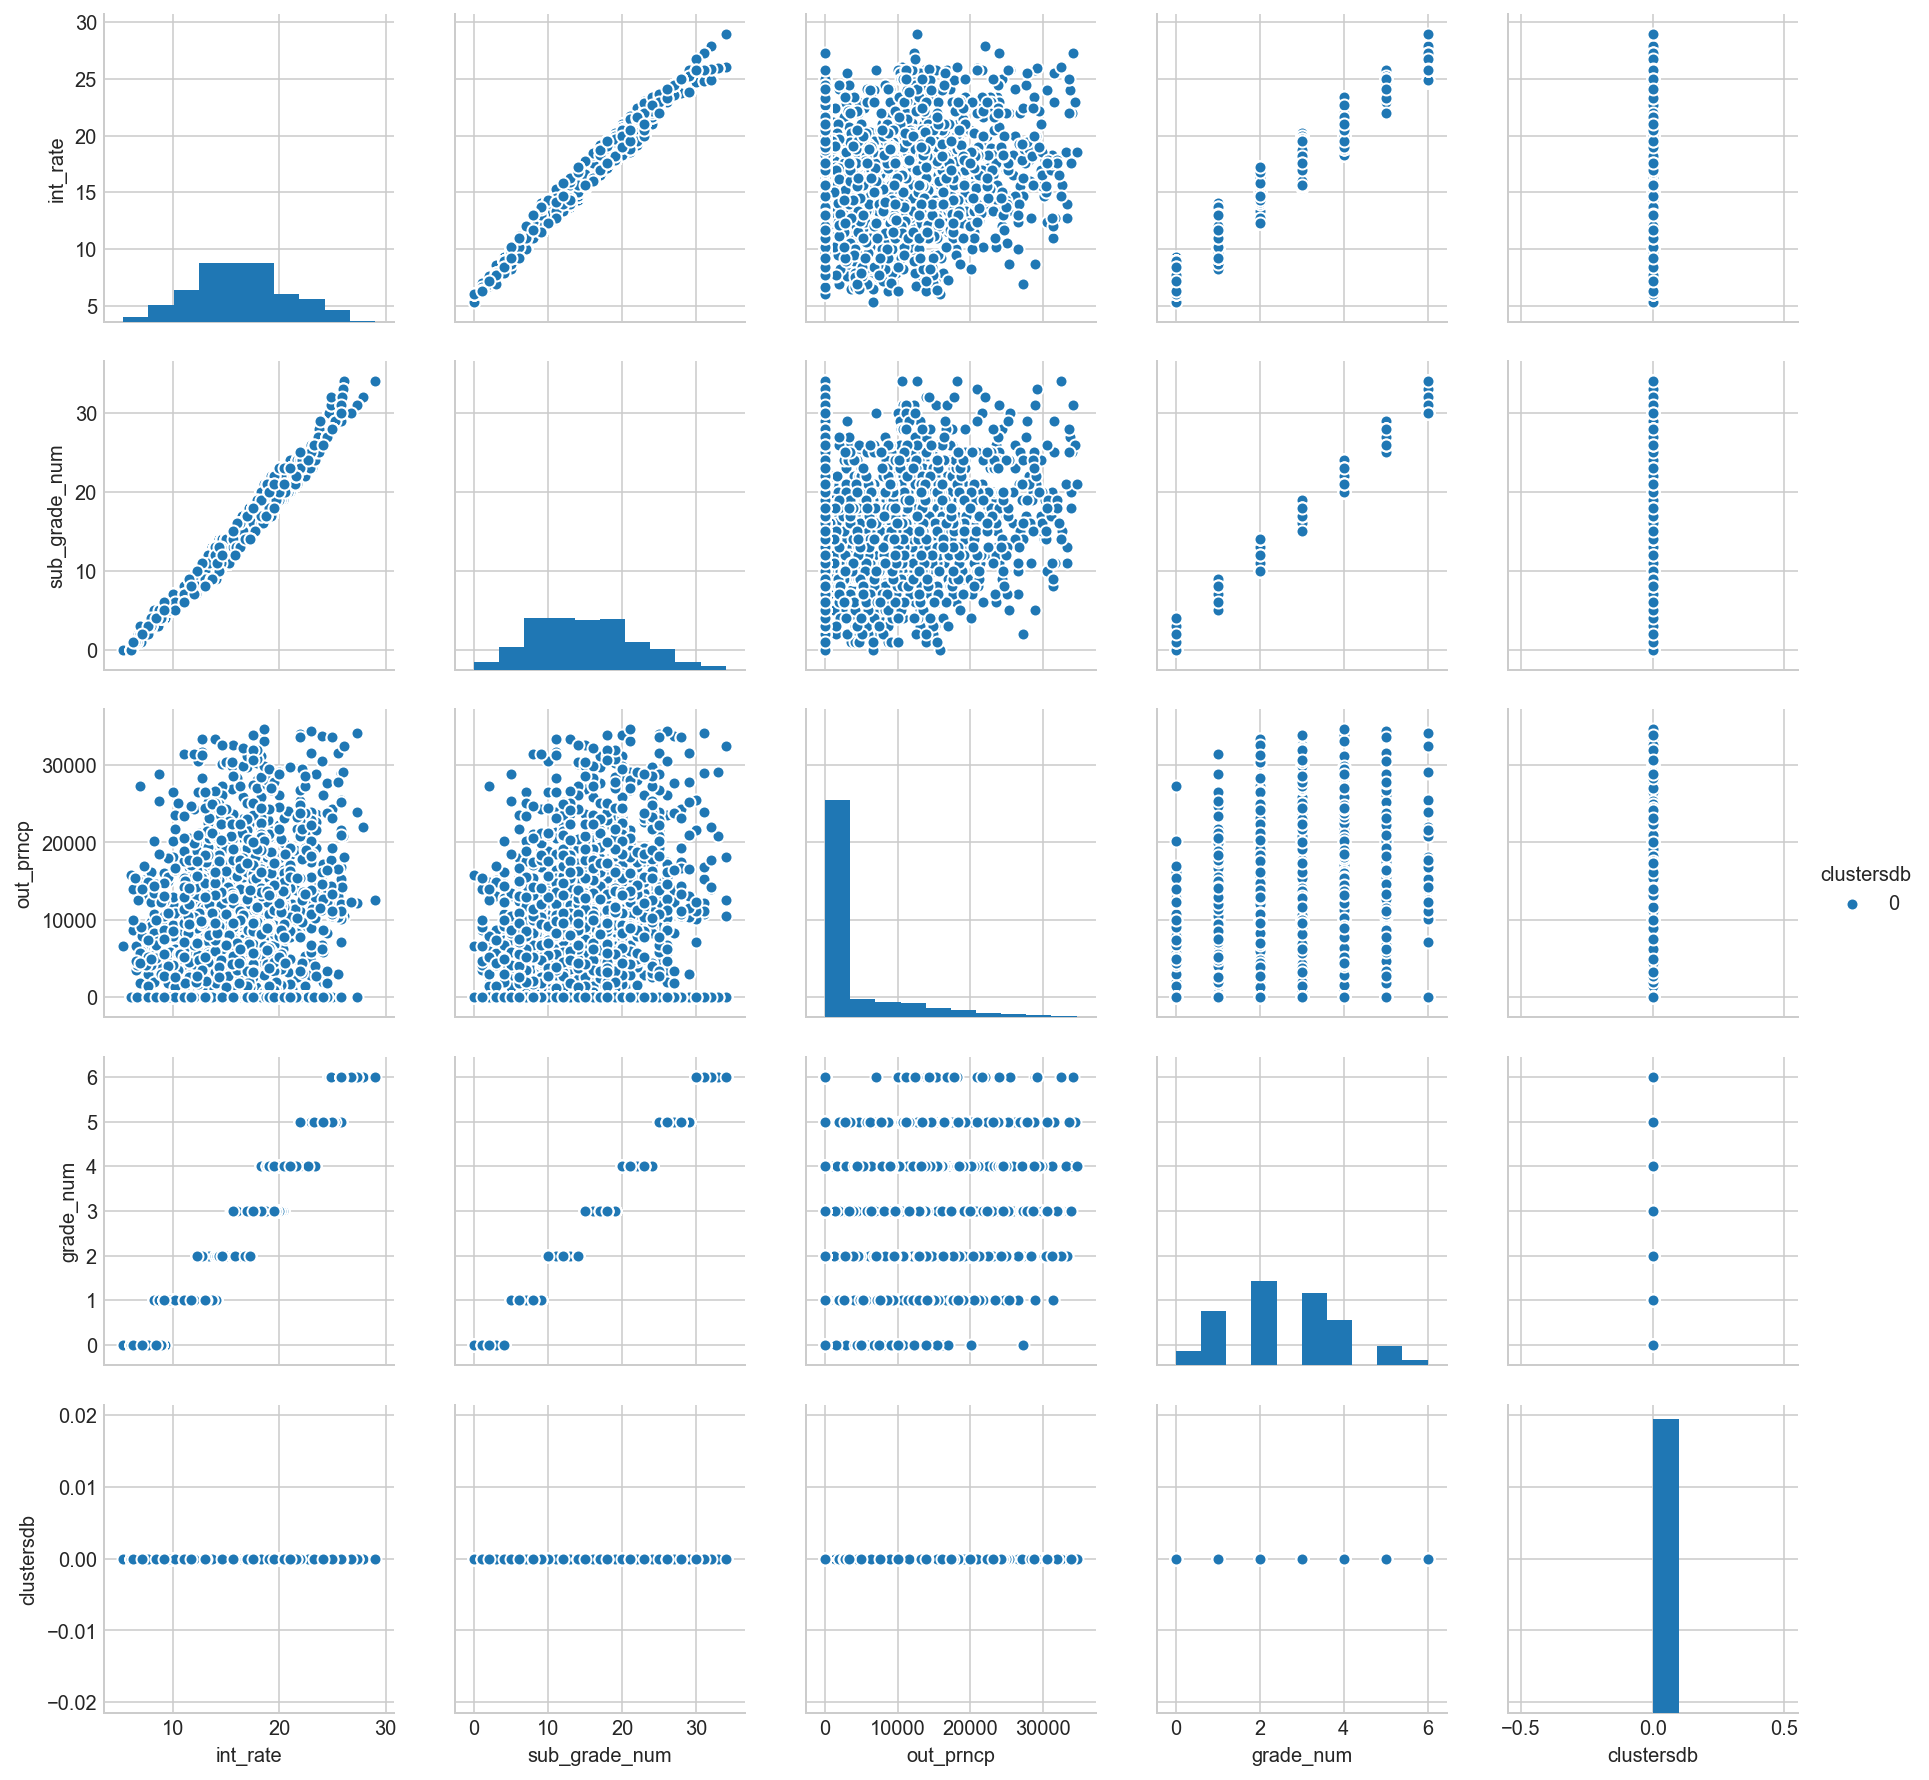

In [84]:
#visually examine the clusters that have been created
#Xdef3 = Xdef3.drop(['clusters'],axis=1)
Xdef3['clustersdb'] = labels
sns.pairplot(data=Xdef3, hue='clustersdb')

#### The Silhouette Score goes up to 0.58, but this is meaningless as the algorithm is predicting only a single cluster. This clustering algorithm will not be considered for eventual analysis.

#### Try Affinity Propogation

In [110]:
# Similar to k-medoids, affinity propagation finds "exemplars", members of the input set that are representative of clusters
afp = AffinityPropagation(damping=0.9, max_iter=200,\
                    convergence_iter=30, copy=True, preference=None, affinity='euclidean', verbose=False)
afp.fit(Xdeff)
labels = afp.labels_
print "Affinity Propogation silhouette Score:\t", silhouette_score(Xdeff, labels)

Affinity Propogation silhouette Score:	0.46408967294492676


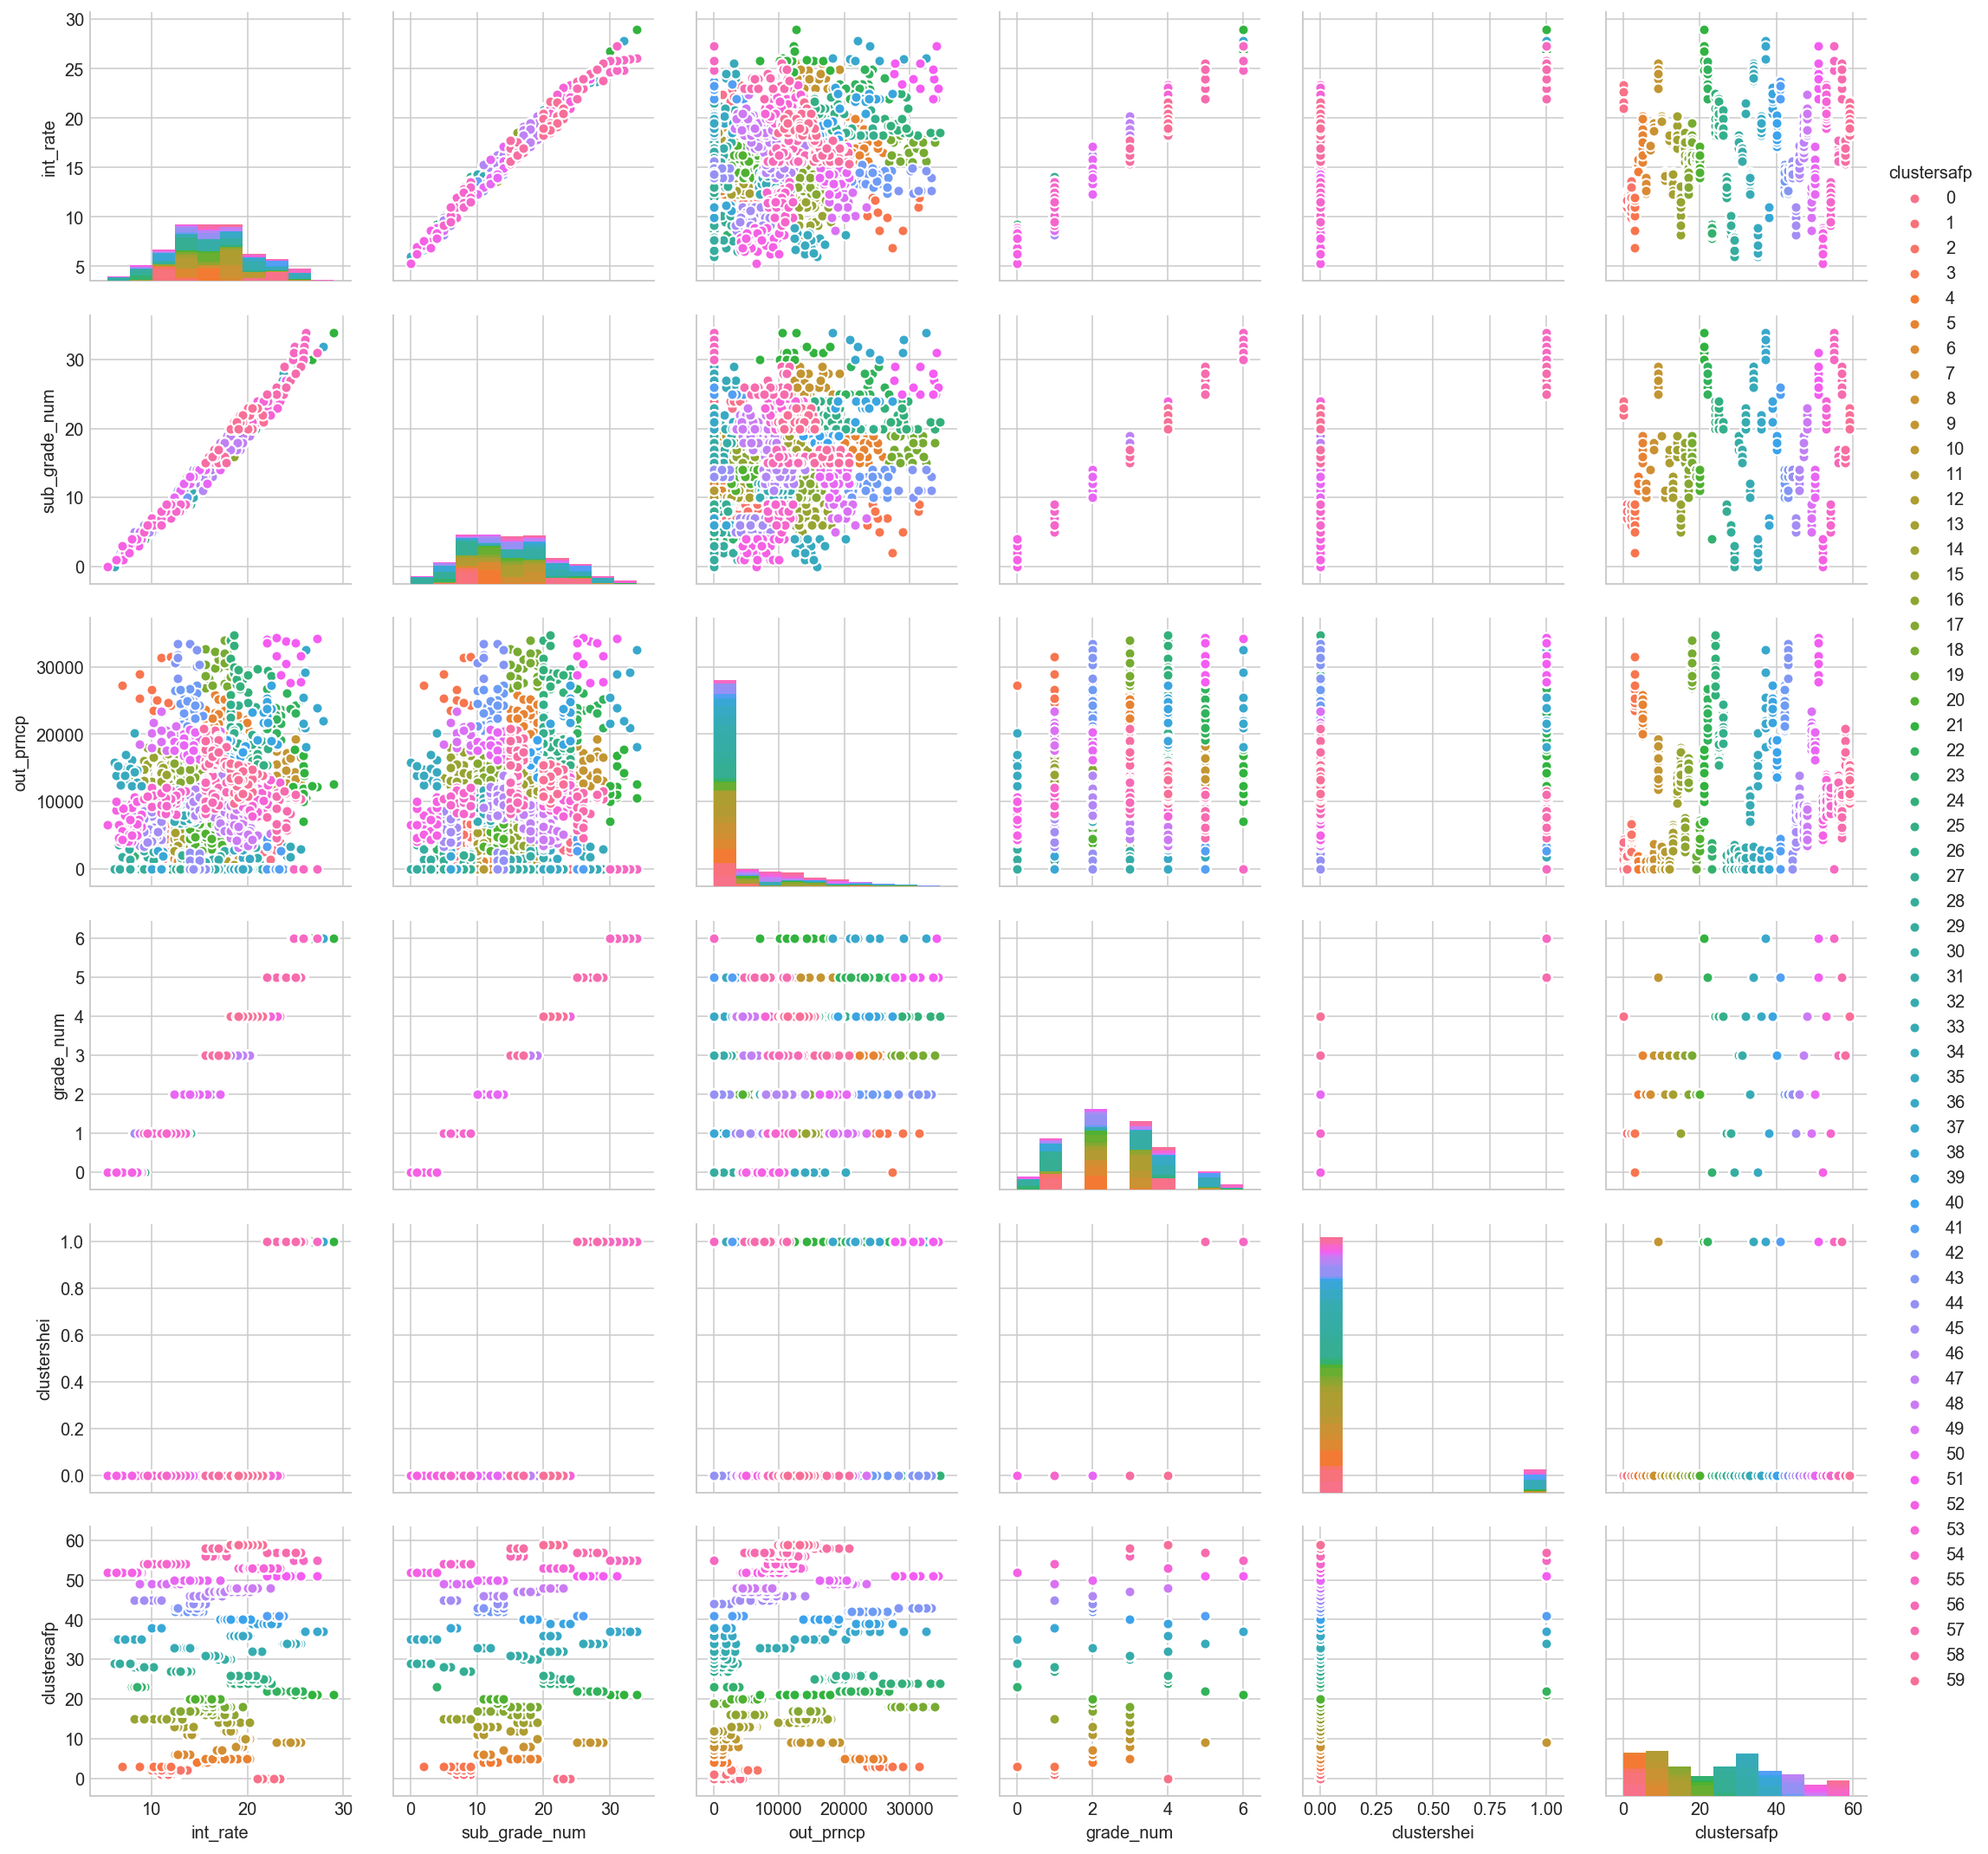

In [111]:
# visually examine the clusters that have been created
Xdef3['clustersafp'] = labels
sns.pairplot(data=Xdef3, hue='clustersafp')

#### Not proceeding further with this model since the number of clusters generated is too large for the output to be of value, and damping values aside from 0.9 do not seem to work

#### Try Heirarchichal Clustering

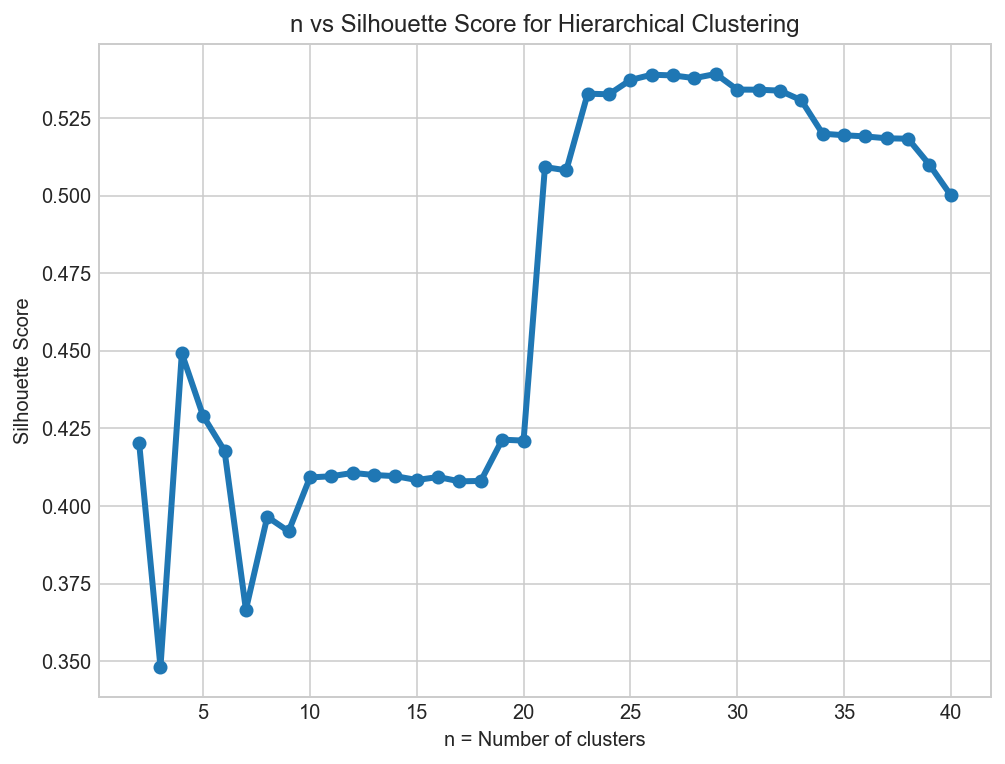

In [95]:
# plotting silhouette results for hierarchical clustering

templist = []
for i in range(2, 41):
    aggc = AgglomerativeClustering(linkage='average',n_clusters=i)
    aggc.fit(Xdeff)
    labels = aggc.labels_
    templist.append(silhouette_score(Xdeff, labels))
    
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(2, 41), templist, lw=3., marker='o')
plt.xlabel('n = Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('n vs Silhouette Score for Hierarchical Clustering')
plt.show()

#### Silhouette Scores are similar to that of KMeans for higher numbers of n, but at these number of clusters the interpretability of the results also drops

#### Use n=2 to get interpretable results for discussion purposes

In [100]:
aggc = AgglomerativeClustering(affinity='l1',n_clusters=2,linkage='average')
aggc.fit(Xdeff)
labels = aggc.labels_
print "Hierarchichal clustering silhouette Score:\t", silhouette_score(Xdeff, labels)

Hierarchichal clustering silhouette Score:	0.4314905739486412


In [101]:
Xdef3 = Xdef3.drop(['clustersdb'],axis=1)

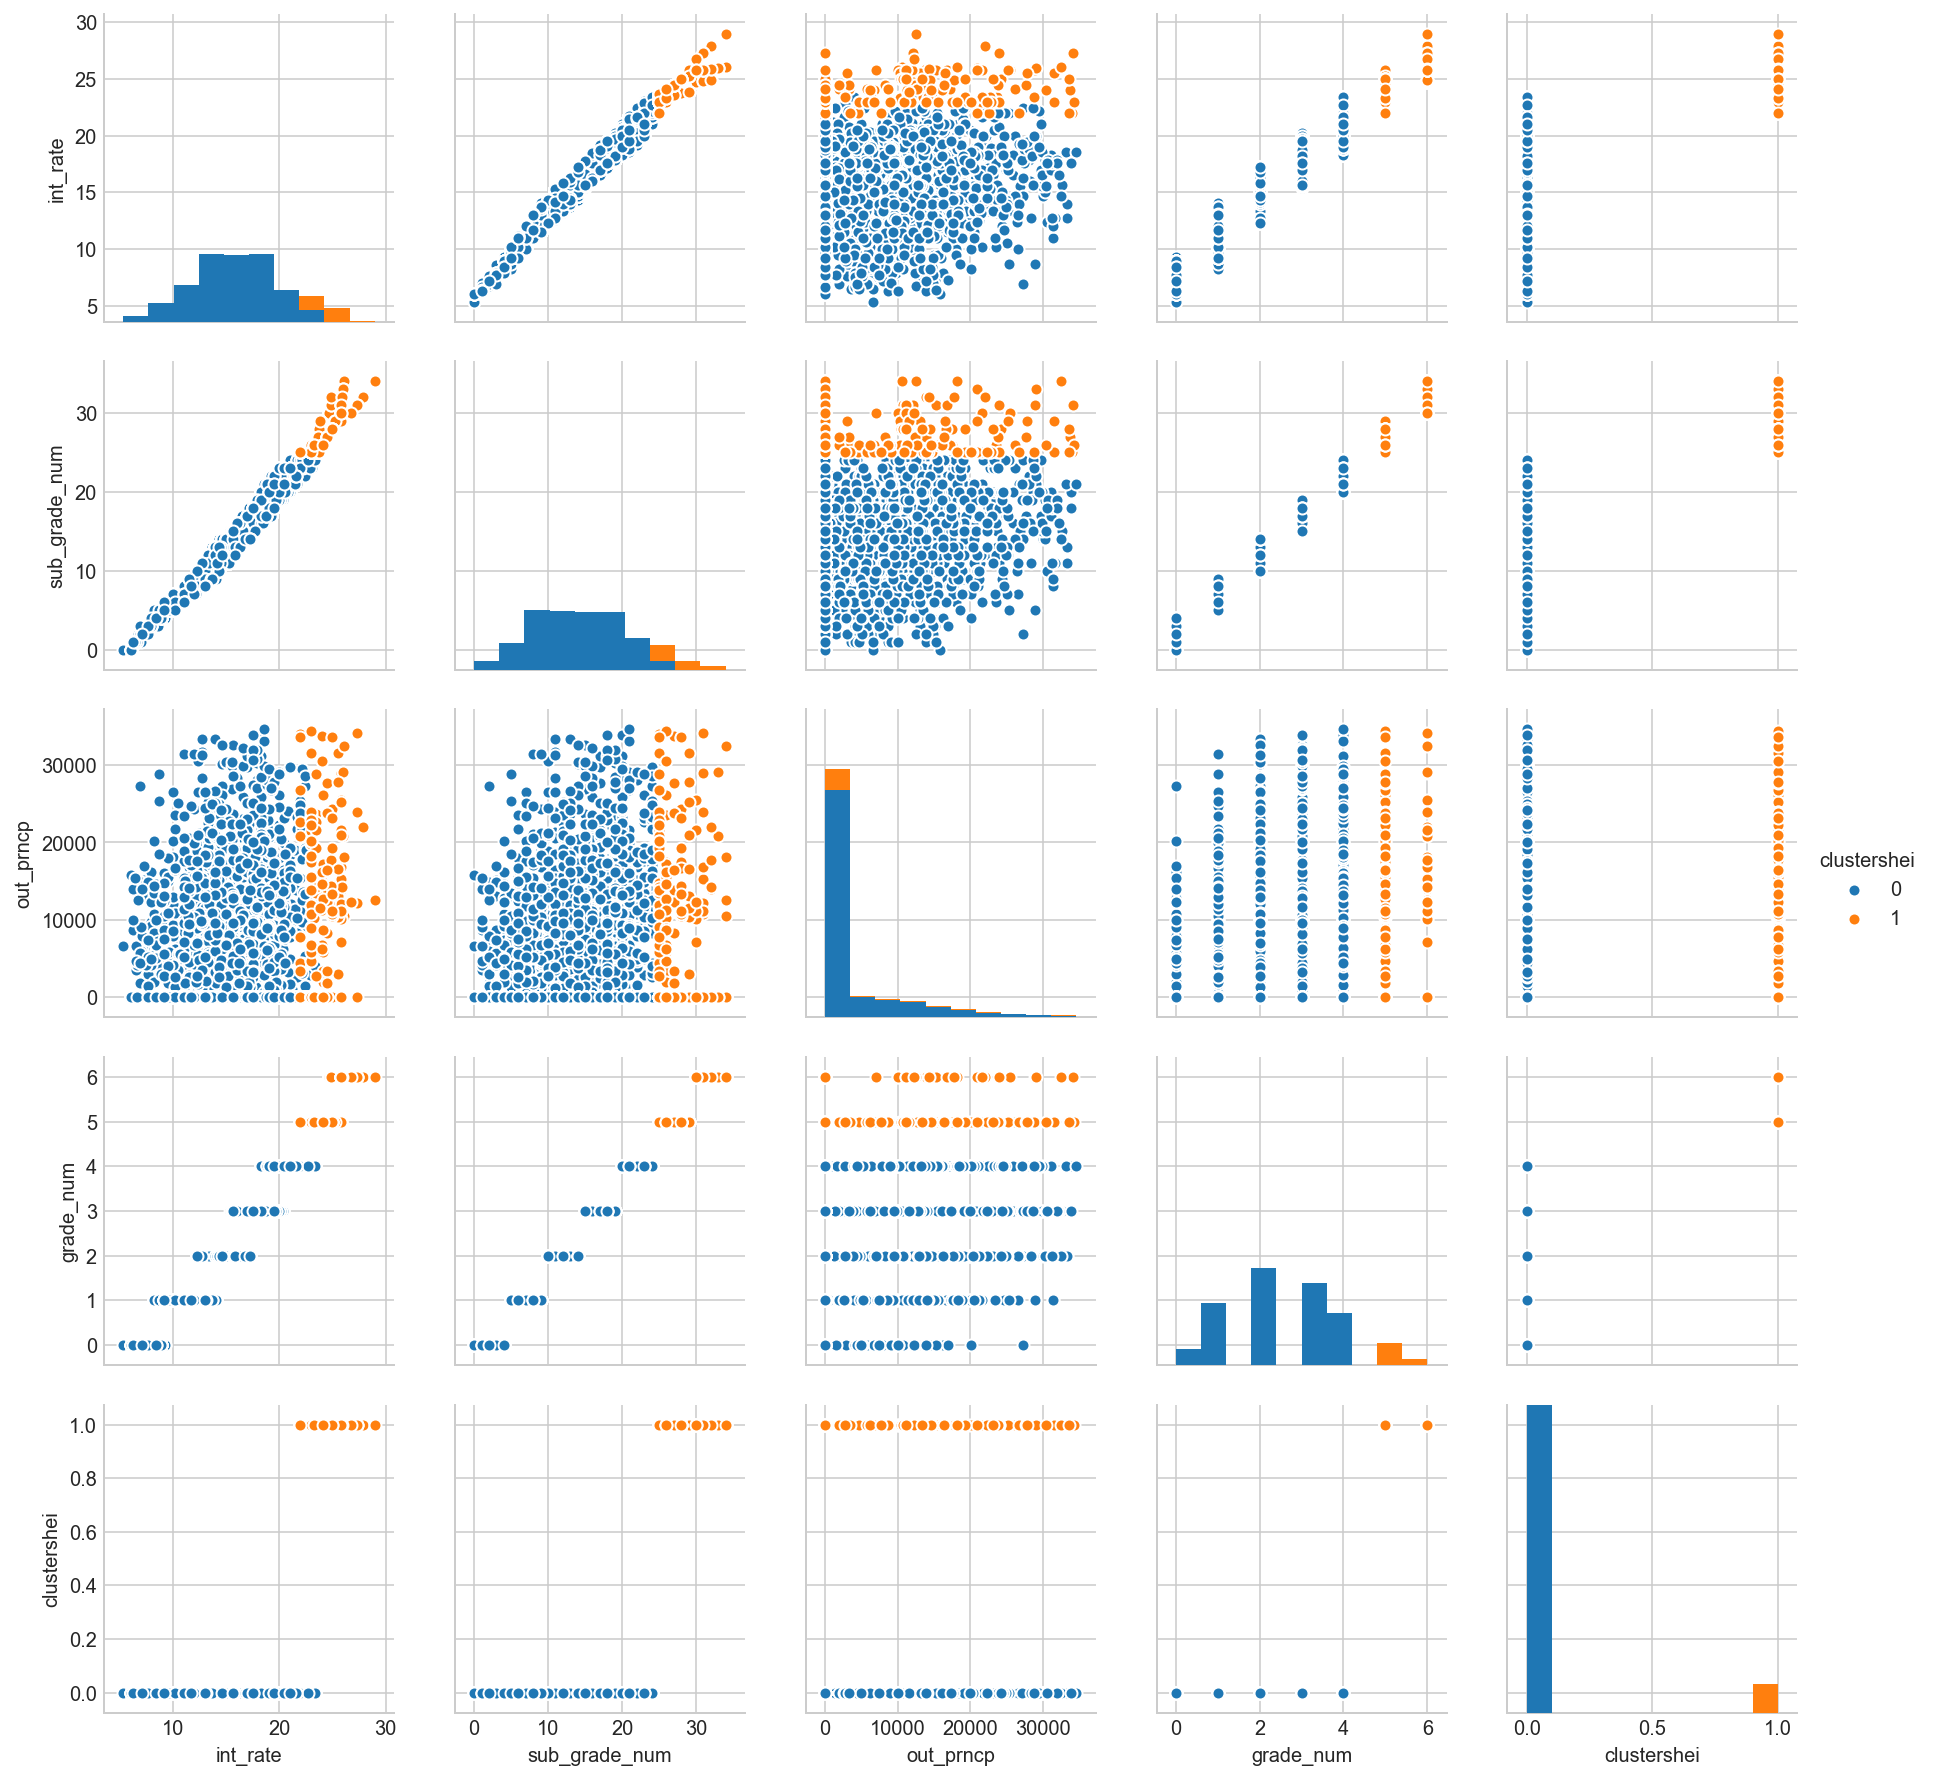

In [102]:
# visually examine the clusters that have been created using robust scaler
Xdef3['clustershei'] = labels
sns.pairplot(data=Xdef3, hue='clustershei')

# Summary of Findings & Results

### Model Performance

#### Using the Silhouette Score measure, the KMeans clustering model and the Hierarchical clustering model have comparable results. However, the score is significantly below 1, indicating that the clusters are not particularly well separated.

#### Best Silhouette Scores:
#### KMeans clustering model - 0.55
#### Hierarchical clustering - 0.54

#### Should a clustering algorithm need to be used for segmentation, the population of defaulters can be segmented using the Hierarchical clustering model into the following two distinct groups (or any other manageable number as deemed appropriate in consultation with business)
#### Group 1 - Borrowers with Credit Subgrades F1 and below 
#### Group 2 - Borrowers with Credit Subgrades E5 and above

### Limitations

#### The selection of the features for clustering analysis was done manually via focusing on demographic data using which the applicants can be easily grouped. This meant that many other features (ie the revolving balance on outstanding credit lines held elsewhere) was excluded.
#### Referencing the RadViz output from earlier, there are no obvious clusters when completing this analysis using the selected features. Hence the clustering is rather arbitrary, and could be potentially completed by creating cutoffs for the feature of interest. An example of such a method would be to create two groups (clusters) consisting of those with assigned interest rates below 10%, and those above.

# Conclusion & Follow-Ups

#### The attempt to cluster the data corresponding to loan defaulters so as to assign the individuals to groups was not entirely successful, largely as a result of limitations surrounding feature selection and the nature of the distribution of data. Assigning manual cutoffs for the target features so as to group the individuals would be a more efficient approach to segment the individuals. 

#### A possible follow-up would be to carry out the clustering analysis using the entire data set without carrying out feature selection beforehand. Additionally, other clustering models and further parameter tuning of the clustering algorithms can be considered should resources allow.